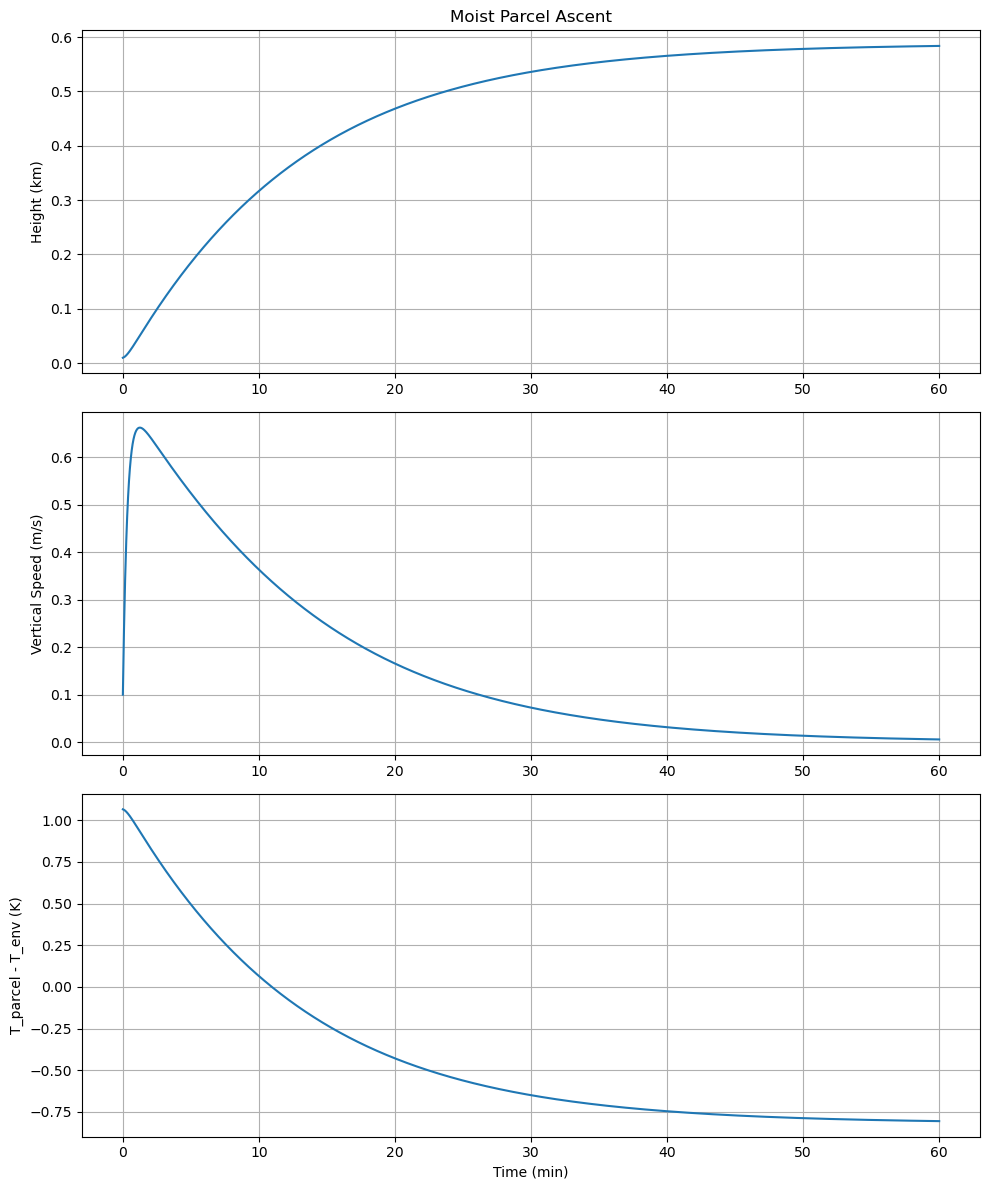

Max height: 0.6 km
Max speed: 0.7 m/s
Final T perturbation: -0.81 K


In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Constants
g = 9.81  # m/s^2
cp = 1005  # J/kg/K
Rd = 287  # J/kg/K
Rv = 461  # J/kg/K
L = 2.5e6  # J/kg/K
eps = 0.622  # Rd/Rv
T0 = 273.15  # K
p0 = 1e5  # Pa
R = Rd  # J/kg/K
epsilon_drag = 0.05  # 1/s, linear drag
mu_entrain = 1e-4  # 1/m, entrainment rate

def sat_mix_ratio(T, p):
    """Saturation mixing ratio q_s(T,p)"""
    es = 611.2 * np.exp(17.67 * (T - T0) / (T - 29.65))  # Pa, Clausius-Clapeyron
    e = es * p / (p + 0.378 * es)  # Partial pressure
    return eps * e / (p - e)

def moist_lapse_rate(T, p):
    """Moist adiabatic lapse rate (K/m)"""
    q_s = sat_mix_ratio(T, p)
    Gamma_d = g / cp * 1e3  # K/km dry
    Lv = L / cp * 1e3  # K
    r = 1 + L * q_s / (Rd * T)
    denom = 1 + (L**2 * q_s * eps) / (cp * Rv * T**2)
    return Gamma_d * r / denom / 1e3  # K/m

# Environment profile (exponential + tropopause)
def env_T(z):
    """Vectorized environment temperature profile for array or scalar z (m)."""
    z = np.asarray(z)
    T = np.empty_like(z, dtype=float)
    mask = z < 15000.0
    T[mask] = 301.0 - 6.5e-3 * z[mask]    # troposphere
    T[~mask] = 216.65                     # tropopause
    return T


def env_q(z):
    return 0.018 * np.exp(-z / 2000)  # kg/kg, decreasing with height

# Time stepping
dt = 1.0  # s
t_max = 3600  # 1 hour
N = int(t_max / dt)
t = np.linspace(0, t_max, N)

# Initial conditions (surface, near saturation)
z = np.zeros(N)
w = np.zeros(N)
T_p = np.full(N, 302.0)  # K, warm SST
q_p = np.full(N, 0.018)  # kg/kg near saturation
p_p = np.full(N, p0)

z[0] = 10.0  # m initial height
w[0] = 0.1   # m/s gentle start

# Integration loop
for i in range(1, N):
    # Current state
    p_env = p0 * np.exp(-z[i-1] / 8000)  # Hydrostatic
    p_p[i] = p_env  # Parcel pressure ≈ environment
    
    T_e = env_T(z[i-1])
    q_e = env_q(z[i-1])
    q_s = sat_mix_ratio(T_p[i-1], p_p[i-1])
    
    # Virtual temperature perturbations
    Tv_p = T_p[i-1] * (1 + 0.608 * q_p[i-1])
    Tv_e = T_e * (1 + 0.608 * q_e)
    
    # Buoyancy acceleration
    B = g * (Tv_p - Tv_e) / Tv_e
    
    # Vertical momentum w/ drag
    dwdt = B - epsilon_drag * w[i-1]
    w[i] = w[i-1] + dwdt * dt
    if w[i] < 0: w[i] = 0  # No descent
    
    # Position update
    z[i] = z[i-1] + w[i] * dt
    
    # Thermodynamics: moist ascent when saturated
    if q_p[i-1] >= q_s * 0.99:  # Saturated
        Gamma_m = moist_lapse_rate(T_p[i-1], p_p[i-1])
        dTdt = -Gamma_m * w[i]
        # Condensation
        dqdt_cond = - (L / cp) * (q_p[i-1] - q_s) * w[i] / 8000  # Simple
    else:  # Unsaturated (dry adiabatic)
        dTdt = - (g / cp) * w[i]
        dqdt_cond = 0
    
    # Entrainment
    dqdt_entr = mu_entrain * (q_e - q_p[i-1]) * np.abs(w[i]) / max(z[i], 100)
    
    # Updates
    T_p[i] = T_p[i-1] + dTdt * dt
    q_p[i] = q_p[i-1] + (dqdt_cond + dqdt_entr) * dt

# Plot results
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 12))

ax1.plot(t/60, z/1000)
ax1.set_ylabel('Height (km)')
ax1.set_title('Moist Parcel Ascent')
ax1.grid(True)

ax2.plot(t/60, w)
ax2.set_ylabel('Vertical Speed (m/s)')
ax2.grid(True)

ax3.plot(t/60, T_p - env_T(z))
ax3.set_ylabel('T_parcel - T_env (K)')
ax3.set_xlabel('Time (min)')
ax3.grid(True)

plt.tight_layout()
plt.show()

print(f"Max height: {np.max(z)/1000:.1f} km")
print(f"Max speed: {np.max(w):.1f} m/s")
print(f"Final T perturbation: {T_p[-1] - env_T(z[-1]):.2f} K")
